In [99]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py

# RH FILTER

## Generating / plotting plant filter

83


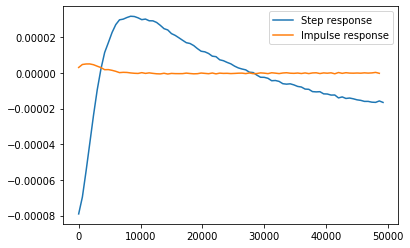

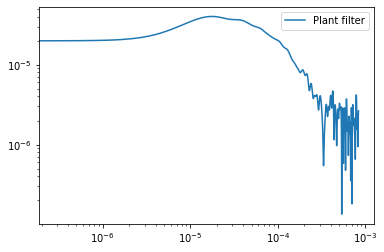

4.993706070287539e-06


In [100]:
ITMYRH_data = np.loadtxt('../data/ITMY_trend_10min_int_longer.dat')
t = np.arange(0,len(ITMYRH_data[:,0][2:]))*60.0*10.0
normalize = 3.13
print(len(t))
data_in = ITMYRH_data[:,1][2:]
b, a = signal.butter(2, .2)
#data_new = signal.filtfilt(b,a,data_in)
data_new = data_in
plt.figure()
ir = (data_new[1:] - data_new[:-1])/normalize
ir_new = ir
plt.plot(t, data_new, label='Step response')
plt.plot(t[:(len(t)-1)], ir, label= 'Impulse response')
plt.legend()
plt.show()

Fs = 1/(t[2]-t[1])
#print(Fs)

[F,H]=signal.freqz(ir_new,1, worN=3000,whole=False) 
plt.figure()
plt.loglog(F*Fs/(2*np.pi), abs(H), label='Plant filter')
plt.legend()
plt.show()


#results = IIRrational.v2.data2filter(
#    data = abs(H),
#    F_Hz = F,
#)
print(max(ir_new))

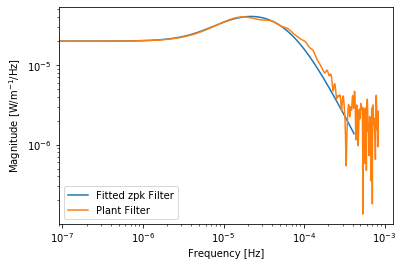

9.729529652779821e-12


In [101]:
#model =  zpk(-2*pi*5e-6, -2.*pi.*[1.3e-5; 9.5e-5; 5e-5],1);

zeros = 5.0e-6
fit_zeros = -2.0*np.pi*5.0e-6
poles = np.array([1.3e-5, 5.0e-5 ,9.5e-5])
fit_poles = -2.0*np.pi*poles

k = 1 #This gain is not initally correct

s1 = signal.ZerosPolesGain(fit_zeros, fit_poles, k)
F_2, H_2 = signal.freqresp(s1, F*(Fs/2.0))

#[F_2,H_2] = signal.freqs(b_2, a_2)
k_new = abs(H[0])/abs(H_2[0])

plt.loglog(F_2/(2*np.pi), abs(H_2)*k_new, label='Fitted zpk Filter')
plt.loglog(F/(2*np.pi)*Fs, abs(H), label='Plant Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

print(k_new) #Spit out the new gain

model_zpk = signal.ZerosPolesGain(fit_zeros, fit_poles,k_new)

## Now to invert the plant filter (just swapping the poles and the zeros and inverting gain)

Text(0.5, 0, 'Frequency [Hz]')

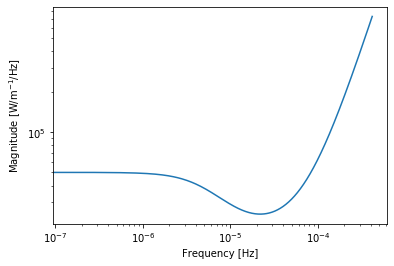

In [102]:
inv_model = signal.ZerosPolesGain(fit_poles, fit_zeros,1/k_new)
F_3, H_3 = signal.freqresp(inv_model, F*(Fs/2.0))
plt.loglog(F_3/(2*np.pi), abs(H_3), label='Fitted zpk Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')

## Stabilize the high frequencies to DC

Text(0.5, 0, 'Frequency [Hz]')

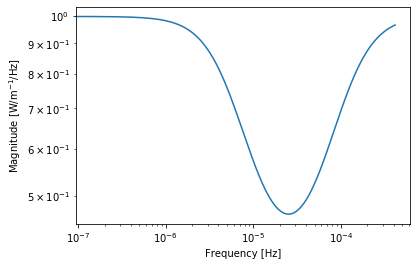

In [103]:
rh_input_filter = signal.ZerosPolesGain(fit_poles, [fit_zeros,-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],1)
F_4, H_4 = signal.freqresp(rh_input_filter,F*(Fs/2.0))
plt.loglog(F_4/(2*np.pi), abs(H_4), label='Fitted zpk Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')

# COMSOL self heating filter [G(s)]

## Import COMSOL self heating data

In [104]:
COM_data = np.loadtxt('../data/1W_self_heating_defocus_doublepass.txt')
t_hrs = COM_data[:,0]
defocus = COM_data[:,1]

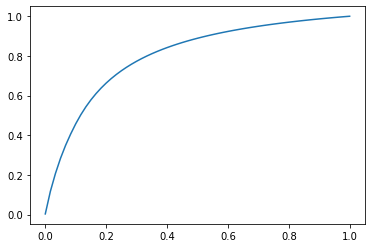

In [105]:
plt.plot(t_hrs,defocus/np.max(defocus))

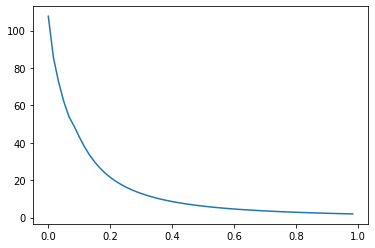

In [106]:
ir_com  = (defocus[1:] - defocus[:-1])
t_ir = t_hrs[:(len(t_hrs)-1)]
plt.plot(t_ir,ir_com)

In [107]:
[F_ir,H_ir]=signal.freqz(ir_com, 1, worN=3000,whole=False) 

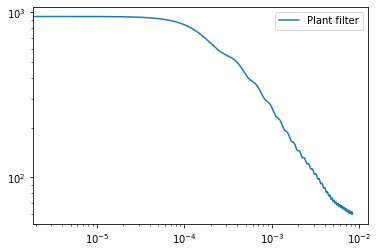

In [108]:
Fs_com = t_hrs[1]-t_hrs[0]*3600
plt.figure()
plt.loglog(F_ir*Fs_com/(2*np.pi), abs(H_ir), label='Plant filter')
plt.legend()
plt.show()

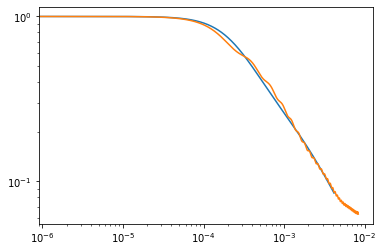

In [109]:
zeros_com = np.array([.9e-3,.3e-3])
fit_zeros_com = -2.0*np.pi*zeros_com
poles_com = np.array([.25e-3,.25e-3,1.6e-3])
fit_poles_com = -2.0*np.pi*poles_com

k_com =1 #This gain is not initally correct

zpk_com = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_com)
F_com, H_com = signal.freqresp(zpk_com, F_ir*(Fs_com/2.0))
k_new_com = abs(H_ir[0])/abs(H_ir[0]*H_com[0])

plt.loglog(F_com/(2*np.pi), abs(H_com)*k_new_com, label='Fitted zpk Filter')
plt.loglog(F_ir*Fs_com/(2*np.pi), abs(H_ir)/abs(H_ir[0]), label='Plant filter')

In [110]:
zpk_com_model = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_new_com)

# Generating the proper time series

In [111]:
lin_thickness=4
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}

In [112]:
unit_step = np.zeros((t.shape[0]*25))
t_new = np.arange(0,len(unit_step))*60.0*1.0
## Generating simulated response
unit_step[t_new>36000] = 1
[t_mod_new,y_mod_sim,xout] = signal.lsim(model_zpk, unit_step, t_new)

In [113]:
[ _ ,y_inp_inv, _] = signal.lsim(rh_input_filter, unit_step, t_new)
[ _ ,y_mod_sim_inv, _] = signal.lsim(model_zpk, y_inp_inv, t_new)

In [114]:
unit_step2 = np.zeros((t.shape[0]*25))
unit_step2[t_new>38000] = 1

In [115]:
[ _ ,y_sh_resp, _] = signal.lsim(zpk_com_model, unit_step2, t_new)

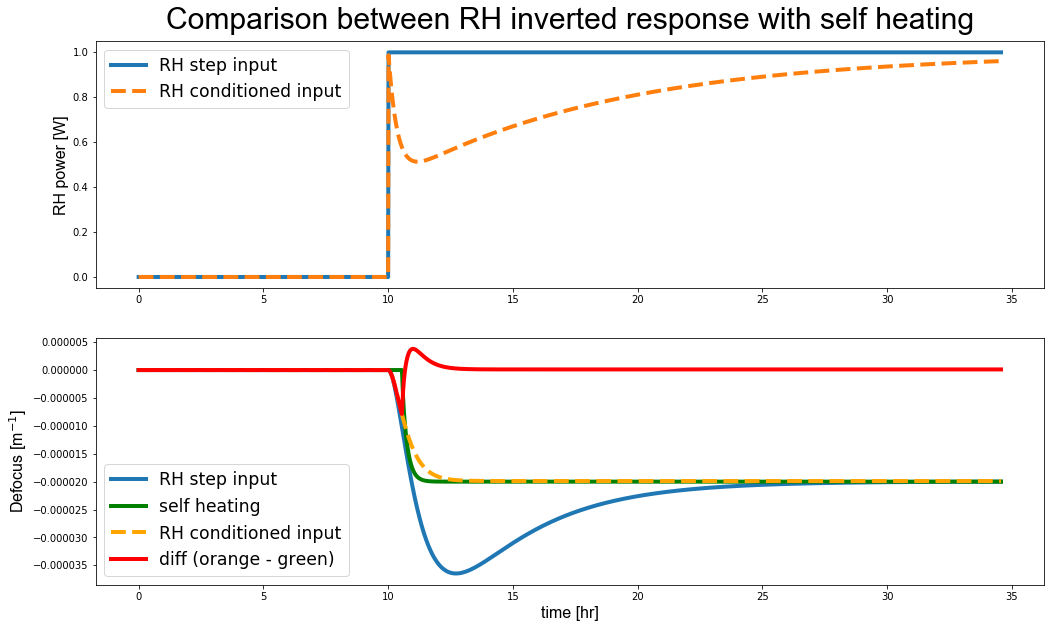

In [116]:
fig = plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='RH step input')
plt.plot(t_new/3600, y_inp_inv,'--', linewidth = lin_thickness,label='RH conditioned input')
plt.ylabel('RH power [W]',**axis_font)
plt.title('Comparison between RH inverted response with self heating',**title_font)
plt.legend(fontsize='xx-large')
plt.subplot(212)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'RH step input')
plt.plot(t_new/3600,-y_sh_resp*20e-6, linewidth = lin_thickness,color='green',label ='self heating')
plt.plot(t_new/3600,-y_mod_sim_inv,'--', linewidth = lin_thickness,color='orange',label ='RH conditioned input')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv,linewidth = lin_thickness,label='diff (orange - green)',color='red')
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.legend(fontsize='xx-large')
fig.savefig('IRHF_compare_w_self.pdf')